In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D, Dense, Add, BatchNormalization, RandomFlip, RandomRotation, Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
import os

In [2]:
!kaggle datasets download -d mahyeks/almond-varieties
!unzip 

Dataset URL: https://www.kaggle.com/datasets/mahyeks/almond-varieties
License(s): CC0-1.0
almond-varieties.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
directory="almond-varieties/dataset"
dataset=image_dataset_from_directory(directory,
                                    labels="inferred",
                                    shuffle=True,
                                    seed=0,
                                    label_mode='categorical',
                                    image_size=(224,224),
                                  )

Found 1525 files belonging to 4 classes.


In [4]:
print(len(dataset)) # Number of batches

48


In [5]:
# Get the size of the dataset
dataset_size = len(dataset)

# Define the split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

In [6]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_dataset=train_dataset.prefetch(AUTOTUNE)

In [7]:
def data_augmentation():
    model=tf.keras.Sequential()
    model.add(Rescaling(scale=1./255))
    model.add(RandomRotation(0.2))
    model.add(RandomFlip('horizontal'))

    return model

In [8]:
def fracture_model(image_size=(224,224)):

    input_shape=image_size+(3,)

    base_model=tf.keras.applications.MobileNetV2(input_shape= input_shape,
                                                 include_top=False,
                                                 weights="imagenet")

    base_model.trainable=False

    Inputs=tf.keras.Input(input_shape)

    x=data_augmentation()(Inputs);

    x=base_model(x,training=False)

    x=Dropout(0.5)(x)
    x=GlobalAveragePooling2D()(x)

    x=Dense(units=1024,activation="relu")(x)

    output=Dense(4,activation="softmax")(x)

    model=tf.keras.Model(inputs=Inputs,outputs=output)

    return model

In [9]:
model=fracture_model((224,224))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(), # Use CategoricalCrossentropy for multi-class problems
              metrics=['accuracy'])

In [11]:
# Now try fitting the model again
epochs=20
history=model.fit(train_dataset,validation_data=val_dataset,epochs=epochs)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 535ms/step - accuracy: 0.6115 - loss: 1.0651 - val_accuracy: 0.9420 - val_loss: 0.2524
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - accuracy: 0.9439 - loss: 0.1822 - val_accuracy: 0.9509 - val_loss: 0.1865
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step - accuracy: 0.9677 - loss: 0.1037 - val_accuracy: 0.9598 - val_loss: 0.1341
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step - accuracy: 0.9291 - loss: 0.1585 - val_accuracy: 0.9554 - val_loss: 0.1592
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step - accuracy: 0.9828 - loss: 0.0623 - val_accuracy: 0.9911 - val_loss: 0.0761
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.9539 - loss: 0.1056 - val_accuracy: 0.9866 - val_loss: 0.0492
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - accuracy: 0.9644 - loss: 0.1123 - val_accuracy: 0.9286 - val_loss: 0.2014
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - accuracy: 0.9726 - loss: 0.0620 - val_accu

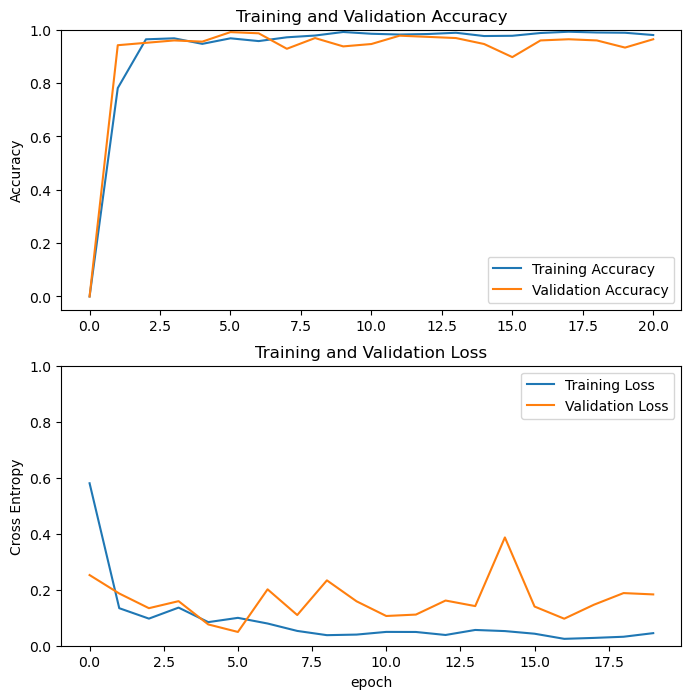

In [12]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

8/8 - 5s - 579ms/step - accuracy: 0.9469 - loss: 0.1625
Test loss: 0.16249288618564606
Test accuracy: 0.9469387531280518
